# Predicting Heart Arrythmias Using Electrocardiograms (ECG)
As indicated, in this repository I use the dataset downloaded from:

Zheng, J., Zhang, J., Danioko, S. et al. A 12-lead electrocardiogram database for arrhythmia research covering more than 10,000 patients. Sci Data 7, 48 (2020). https://doi.org/10.1038/s41597-020-0386-x

It contains 12-lead (channel) ECG files of over 10,000 patients

## Data Exploration

### Diagnostics and Simple features
The data, in the folder 'ECG_Data' will not be added to the repository. To download the required files please refer to the source.

All the ECGs of all patients are included in the subfolder 'Denoised'

We have a main table 'Diagnostics.xlsx' that includes the following information about each of the patients:
- IDs (filenames)
- Medical diagnosis of the heart rythm and heart beat conditions
- Each patient's age and gender
- 12 columns corresponding to 12 features automatically extracted during the ECG recording using the [GE MUSE Cardiology Information System](https://www.gehealthcare.com/en-ph/products/diagnostic-ecg/cardio-data-management/muse-v9) including the ventricular and atrial rate, and the average duration, onset and offset of each ECG curve event.

The file 'AttributesDictionary.xlsx' describes the data type of each of the columns in Diagnostics (that can be accessed with the function pd.dtype()) and the description of each.

'ConditionName.xlsx' contains informationa bout the diagnosed beat conditions, that will not be used in this analysis.

Finally, 'RythmNames' includes the full names of each of the heart arrythmias.

In [264]:
# Import the necessary Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [265]:
# Load the main Database Files
Attributes = pd.read_excel('ECG_Data/AttributesDictionary.xlsx')
Rhythms = pd.read_excel('ECG_Data/RhythmNames.xlsx')
Diagnostics = pd.read_excel('ECG_Data/Diagnostics.xlsx')

# Remove beat conditions as their classification is not the purpose of this analysis
Diagnostics = Diagnostics.drop('Beat', axis=1)

Attributes contains the attributes of the diagnostics table:

In [266]:
display(Attributes)

,Attributes,Type,ValueRange,Description
0,FileName,String,NaN,ECG data file name(unique ID)
1,Rhythm,String,NaN,Rhythm Label
2,Beat,String,NaN,Other conditions Label
3,PatientAge,Numeric,0-999,Age
4,Gender,String,MALE/FEMAL,Gender
5,VentricularRate,Numeric,0-999,Ventricular rate in BPM
6,AtrialRate,Numeric,0-999,Atrial rate in BPM
7,QRSDuration,Numeric -,0-999,QRS duration in msec
8,QTInterval,Numeric,0-999,QT interval in msec
9,QTCorrected,Numeric,0-999,Corrected QT interval in msec


We will now visualize the main columns in the Diagnostics table. 
We can see that the database contains data of the ECG of 10646 patients. 
There is a hight variablity in most of the extracted features of the ECG as a consequence of the heart conditions, so probably these will be important for the diagnosis.

In [267]:
Diagnostics.describe()

,PatientAge,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
count,10646.000000,10646.000000,10646.00000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000
mean,59.186831,84.136107,92.57787,90.989292,384.150855,434.154048,39.620609,44.637704,13.839470,219.260567,264.755213,411.335995
std,18.030019,34.455349,60.09394,17.479540,59.226289,39.354182,41.212648,57.478092,5.676339,6.410413,8.362120,29.777404
min,4.000000,34.000000,0.00000,18.000000,114.000000,219.000000,-89.000000,-89.000000,5.000000,159.000000,249.000000,281.000000
25%,49.000000,57.000000,57.00000,80.000000,344.000000,408.000000,14.000000,19.000000,9.000000,216.000000,259.000000,392.000000
50%,62.000000,73.000000,72.00000,88.000000,390.000000,430.000000,46.000000,42.000000,12.000000,219.000000,264.000000,414.000000
75%,72.000000,104.000000,106.00000,98.000000,426.000000,456.000000,68.000000,62.000000,17.000000,224.000000,268.000000,432.000000
max,98.000000,263.000000,535.00000,256.000000,736.000000,760.000000,270.000000,270.000000,40.000000,240.000000,331.000000,582.000000


The Rythms of the columns in index 1 are described in the Rythms dataframe. Here we display how many counts we have for each class.
Notice that the label 'SA' is incorrect, it should be 'SI', corresponding to Sinus Irregularity

,Acronym Name,Full Name
0,SB,Sinus Bradycardia
1,SR,Sinus Rhythm
2,AFIB,Atrial Fibrillation
3,ST,Sinus Tachycardia
4,AF,Atrial Flutter
5,SI,Sinus Irregularity
6,SVT,Supraventricular Tachycardia
7,AT,Atrial Tachycardia
8,AVNRT,Atrioventricular Node Reentrant Tachycardia
9,AVRT,Atrioventricular Reentrant Tachycardia


SB       3889
SR       1826
AFIB     1780
ST       1568
SVT       587
AF        445
SA        399
AT        121
AVNRT      16
AVRT        8
SAAWR       7
Name: Rhythm, dtype: int64


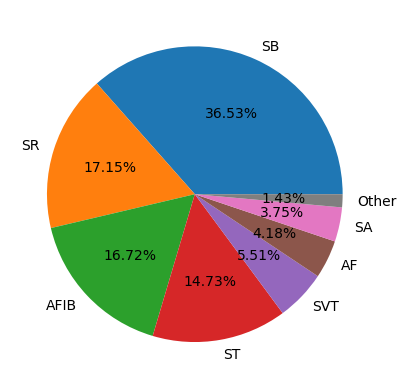

In [268]:
# Labels of each of the rythms
display(Rhythms)

# Display the counts of each arrythmia type in the Diagnostics DF
Rhythm_counts = Diagnostics['Rhythm'].value_counts()
print(Rhythm_counts)

# Plot the counts as a pie chart
## Group as other when <100 counts
thres = 150
rhythm_labels = Rhythm_counts[Rhythm_counts>thres].index.to_list() + ['Other']
rhythm_counts = Rhythm_counts[Rhythm_counts>thres].tolist() + [Rhythm_counts[Rhythm_counts<thres].sum()]
## Plot Pie Chart
plt.figure()
plt.pie(rhythm_counts, labels=rhythm_labels, autopct='%1.2f%%')
plt.show()

In [269]:
print(Diagnostics['Rhythm'].value_counts())

SB       3889
SR       1826
AFIB     1780
ST       1568
SVT       587
AF        445
SA        399
AT        121
AVNRT      16
AVRT        8
SAAWR       7
Name: Rhythm, dtype: int64


We can see that there is a huge data imbalance with Sinus Bradycardia, Sinus Rhythm (healthy), atrial fibrillationa nd sinus tachycardia representing around 85% of all classes. As adviced by cardiologists in the study, we will initially group the 11 rhythms into 4 main classes: SB, AFIB, GSVT, SR
1. SB -> Sinus bradycardia
2. AFIB -> atrial fibrillation and atrial flutter (AF)
3. GSVT ->   supraventricular tachycardia, atrial tachycardia, atrioventricular node reentrant tachycardia, atrioventricular reentrant tachycardia and sinus atrium to atrial wandering rhythm
4. SR -> sinus rhythm and sinus irregularity -> normal rhythm

And now we can see that these four classes are relatively balanced, with a bias towards Sinus Bradycardia

SB      3889
GSVT    2307
AFIB    2225
SR      2225
Name: Rhythm, dtype: int64


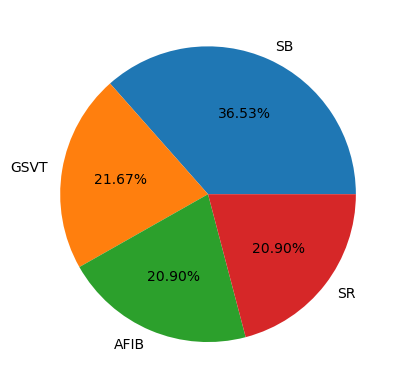

In [270]:
# Dictionary with the 4 groups
#Diagnostics = pd.read_excel('ECG_Data/Diagnostics.xlsx')

Rythms_groups = {'SR':['SR', 'SA'], # SA = sinus irregularity, bad label
                 'AFIB':['AF', 'AFIB'], 
                 'GSVT':['SVT','AT', 'AVNRT', 'AVRT', 'SAAWR', 'ST'],
                 'SB':['SB']}
reverse_groups = {val: key for key, values in Rythms_groups.items() for val in values}

Diagnostics['Rhythm'] = np.array([reverse_groups.get(i, None) for i in Diagnostics['Rhythm']])

# Display the counts of each arrythmia type in the Diagnostics DF
Rhythm_counts = Diagnostics['Rhythm'].value_counts()
print(Rhythm_counts)

# Plot the counts as a pie chart
plt.figure()
plt.pie(Rhythm_counts, labels=Rhythm_counts.index, autopct='%1.2f%%')
plt.show()

If we plot the frequency distributions of all features for each of the groups, we can see that only some of them, including the ventricular rate, atrial rate, QT interval QRS count and Toffset help discern each of the classes

FileName           object
Rhythm             object
PatientAge          int64
Gender             object
VentricularRate     int64
AtrialRate          int64
QRSDuration         int64
QTInterval          int64
QTCorrected         int64
RAxis               int64
TAxis               int64
QRSCount            int64
QOnset              int64
QOffset             int64
TOffset             int64
dtype: object


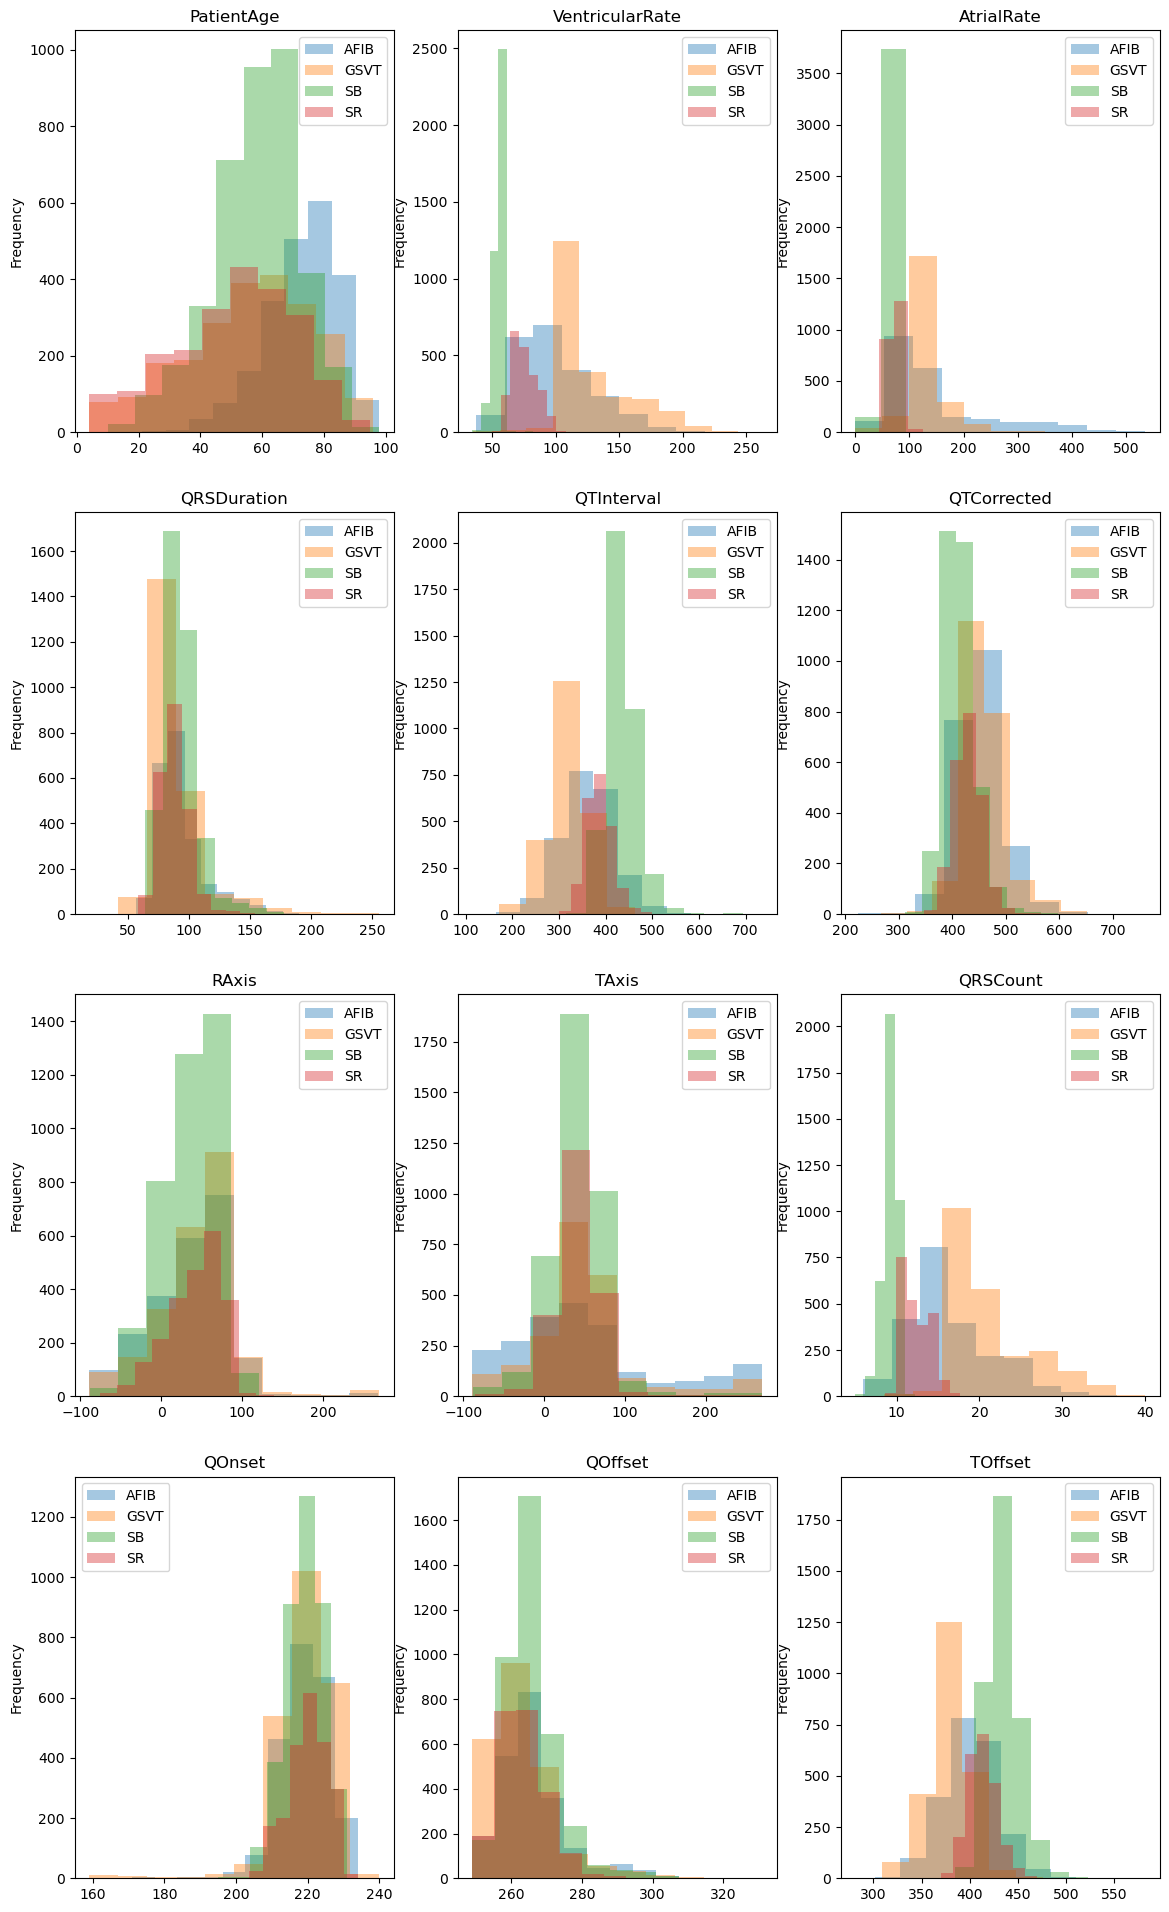

In [271]:
print(Diagnostics.dtypes)

# Convert gender to 0 and 1 code
#Diagnostics['Gender'] = Diagnostics['Gender'].map({'MALE': 1, 'FEMALE': 0})

# Plot each column histogram by each group
groups = Diagnostics.groupby('Rhythm')
int_columns = Diagnostics.select_dtypes('int64').columns

## Calculate the number of rows and columns for the subplots
n = len(int_columns)
ncols = 3 
nrows = n // ncols + (n % ncols > 0)

## Create a new figure with subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(14, 6*nrows))
axs = axs.flatten()

for ax, column in zip(axs, int_columns): # Each column
    for name, group in groups: # Each group
        # Plot the values of the current column and group in the subplot
        group[column].plot(kind='hist', alpha=0.4, label=name, ax=ax)

    ax.legend()
    ax.set_title(column)  # column name as title

## Remove unused subplots
for i in range(n, nrows*ncols):
    fig.delaxes(axs[i])

plt.show()


## Extraction of ECG leads Features

Until now we have a mroe or less balanced dataset with a few key features that can help diagnose each patient's arrhythmias. In this section we will see how to extract more features using the 12 lead ECG of each patient. The whole dataset occupies ~4.5GB

For this we will compare the biological signal processing libraries [BioSPPy](https://github.com/PIA-Group/BioSPPy) and [NeuroKit2](https://github.com/neuropsychology/NeuroKit)

The ECGs come already denoised using [ECGDenoisingTool](https://github.com/zheng120/ECGDenoisingTool/tree/master). First, they utilized a Butterworth low pass filter to eliminate signals with a frequency greater than 50 Hz. Following that, they applied a local polynomial regression smoother (LOESS) to mitigate the effects of baseline wandering. Finally, they employed the Non Local Means (NLM) technique to manage any remaining noise. If we had noisy data, we could use scipy.signal, or otherwise BioSPPy and NeuroKit2 also provide automatic noise filtering functions.

Each ECG has the following Channels: 'I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5' and 'V6'. 

In each channel we can detect with more or less precission, the QRS, P, T valleys and peaks variables as described here: ![Image](https://www.researchgate.net/profile/Sucharita-Mitra/publication/324762381/figure/fig1/AS:622232514613253@1525363200208/Typical-ECG-signal-with-its-distinctive-points-see-online-version-for-colours.png)
[S. Mitra, et al., 2018, IJCSYSE](10.1504/IJCSYSE.2018.10012644)

Given the importance of explainability in healthcare to be able to explain which variables help predict each condition, we will extract the following features from all 12 leads:

### QRS Complex
- Mean height Q
- Var height Q
- Mean width Q
- Var height Q
- Mean prominence Q
- Var prominence Q
- Mean height R
- Var height R
- Mean width R
- Var height R
- Mean prominence R
- Var prominence R
- Mean height S
- Var height S
- Mean width S
- Var height S
- Mean prominence S
- Var prominence S

### Non-QRS
- Mean height P
- Var height P
- Mean width P
- Var height P
- Mean prominence P
- Var prominence P
- Mean height T
- Var height T
- Mean width T
- Var height T
- Mean prominence T
- Var prominence T

### Frequency Bands
According to some [studies](https://www.sciencedirect.com/science/article/pii/S0898122107005019), different heart conditions have differences in the frequency bands of 0-4 and 4-12. To extract some simplified features I will extract the mean power of low (0-4), mid(4-12) and high (12-30) frequency


In [318]:
# Import BioSPPy and NeuroKit2 libraries:
from biosppy import utils
from biosppy import signals
import neurokit2 as nk

# Data directory and list of patients
data_dir = 'ECG_Data/Denoised/'
patient_list = os.listdir(data_dir)

# Channels of each ECG file
channels = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

We will first visualize all channels of sample ECGs for each condition.
We can observe that all patients have completely different ECG. Thus, we can extract more features from all 12 leads that can help a classification algorithm to diagnose the different arrythmias.
For this we will try Neurokit2 and BioSPPy

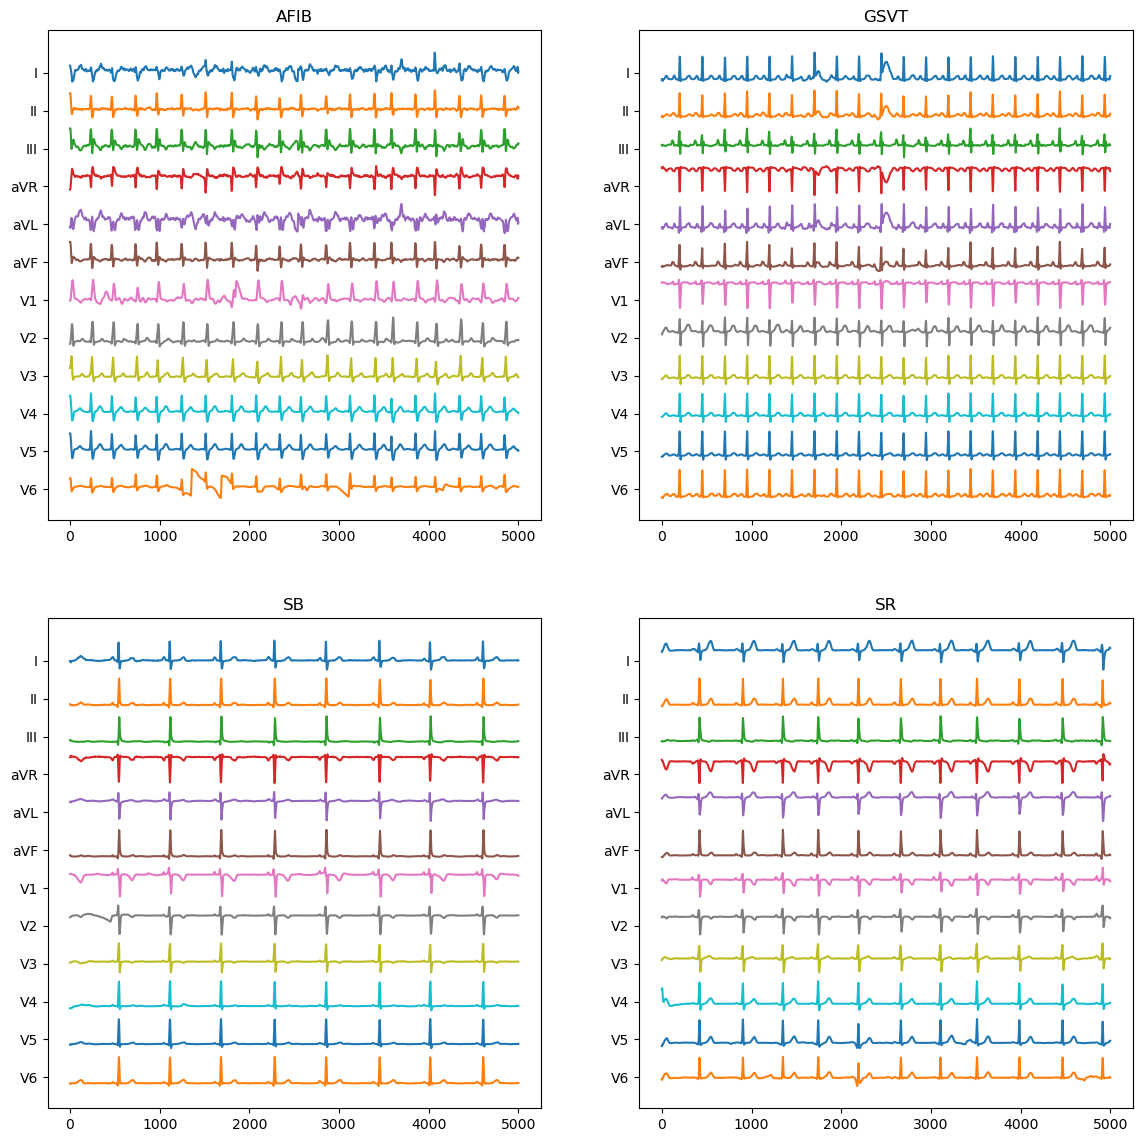

In [319]:
# Import Patient data
# Get one example of each group
patients = Diagnostics.groupby('Rhythm')['FileName'].first() +'.csv'
rhythms = patients.index.to_list()

# Load data  and visualize all ECG channels
fig, axs = plt.subplots(2, 2, figsize=(14, 14))
axs = axs.flatten()

count = -1 # counter
for ax, patient in zip(axs, patients): # Iterate through patients
    # Load patient data
    patient = pd.read_csv(os.path.join(data_dir, str(patient)), header=None, names=channels)

    count +=1 # counter
    y_ticks = [] # append to change yticks with channels

    for i, channel in enumerate(channels): # iterate through channels
        ecg_ch = patient[channel].to_numpy()
        # Min max normalization, -1.3*i to plot each channel below 
        min_max_ecg = (ecg_ch-np.min(ecg_ch)) / (np.max(ecg_ch)-np.min(ecg_ch)) - 1.3*i
        y_ticks.append(-1.3*i+.3) # 
        ax.plot(min_max_ecg)

    _ = ax.set_yticks(y_ticks, channels)

    ax.set_title(rhythms[count])

plt.show()

### Feature extraction with NeuroKit2 
Neurokit2 works quite well when we use the standard 'II' channel of a healthy patient. However, when we try other channels, specially in an unhealthy patient, it struggles detecting the PQRST peaks and valleys. The advantage is that they allow the usage of [multiple algorithms](https://neuropsychology.github.io/NeuroKit/studies/ecg_benchmark.html) to detect the different features, but it has problems with this dataset independently of the method used, both using noised (and their cleaning function) or the denoised dataset. Here we will see a couple of examples one of SR (normal) and one of an AFIB patient.

In [334]:
# Import Patient data
patients = Diagnostics.groupby('Rhythm')['FileName'].first() +'.csv'
patients = patients[patients.index.isin(['SR', 'AFIB'])]
rhythms = patients.index.to_list()

# Detect the R peaks for the II and V5 ECG leads
_, rpeaks = nk.ecg_peaks(patients[0]['II'], sampling_rate=500, method='neurokit')
#plot = nk.events_plot(rpeaks['ECG_R_Peaks'], patient['II'])
#_, waves_peak = nk.ecg_delineate(x[4][1], rpeaks, sampling_rate=1000, method="peak")
#print(rpeaks)

TypeError: string indices must be integers

Here we visualize the code

In [315]:
_, waves_peak = nk.ecg_delineate(patient['V5'], rpeaks, sampling_rate=500, method="dwt")
plot = nk.events_plot([waves_peak['ECG_T_Peaks'], 
                       waves_peak['ECG_P_Peaks'],
                       waves_peak['ECG_Q_Peaks'],
                       waves_peak['ECG_S_Peaks']], patient['V5'])


_, waves_peak = nk.ecg_delineate(patient['II'], rpeaks, sampling_rate=500, method="dwt")
plot = nk.events_plot([waves_peak['ECG_P_Peaks'], 
                       waves_peak['ECG_P_Onsets'],
                       waves_peak['ECG_P_Offsets']], 
                       patient['II'])

NameError: name 'rpeaks' is not defined